In [3]:
import spectral as spy
from PIL import Image
import numpy as np
import re
from scipy import interpolate
import matplotlib.pyplot as plt
import math

Albedo start long: 8138692.0112 and delta: 100.0
Albedo start lat: -278280.2154 and delta: 100.0
TI start long: 8126176.071377343 and delta: 100.0
TI start lat: -269599.34795088397 and delta: 100.0
Albedo start long: 8138692.0112 and delta: 100.0
Albedo start lat: -278280.2154 and delta: 100.0
Mapping TI to albedo domain...
Mapping TI to albedo domain...done!
Retrieving temperature map...
Retrieving temperature map...done!
Saving E:\BAM\Simulation_Test\FRT0000B6F1_NN_09_04_18\FRT0000B6F1_TI_LA\thermal_model_T_Output_Arvidson_8degree.img


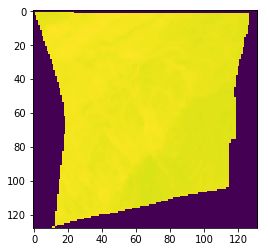

In [4]:
albedo_file = "E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/FRT0000B6F1_07_IF165L_TRR3_corr_despiked_FRT0000B6F1_td33_ti11_vs_soc_iof_med25_tol00625_var25_half3_lambert_mlm_albedo_mu_iter_40_proj100.hdr"
band_num = 0
TI_file = "E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/combined_ti_reference.tiff"
thermal_model_file1 = "E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/Output_Arvidson_FRT0000B6F1_00tilt_000az.txt"
degree1 = 0
degree2 = 10
degree = 8
thermal_model_file2 = "E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/Output_Arvidson_FRT0000B6F1_10tilt_323az.txt"
T_savefile = 'E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/thermal_model_T_Output_Arvidson'

# Read albedo and TI
albedo = spy.open_image(albedo_file).read_band(band_num)
TI = Image.open(TI_file)
TI_lon_start, TI_lat_start = TI.tag[33922][3:5]
TI_lon_del, TI_lat_del = TI.tag[33550][0:2]
TI = np.array(TI)
TI_num_row, TI_num_col = TI.shape
fh = open(albedo_file)
proj = ''
flag = False
for line in fh:
    # in python 2
    # print line
    # in python 3
    if "map info" in line:
        tmp = line.split(',')
        lon_start, lat_start, lon_del, lat_del = tmp[3:7]
        lon_start = float(lon_start)
        lat_start = float(lat_start)
        lon_del = float(lon_del)
        lat_del = float(lat_del)        
        proj += line
        flag = True
    if "projection info" in line:
        tmp = line.split(',')
        r,lat_offset, lon_offset = tmp[1:4]
        r = float(r)
    if flag:
        if "wavelength units" in line:
            break
        else:
            proj += line
lon_start = lon_start + float(lon_offset)/180*math.pi*r
lat_start = lat_start + float(lat_offset)/180*math.pi*r
fh.close()
print("Albedo start long: "+str(lon_start)+" and delta: "+str(lon_del))
print("Albedo start lat: "+str(lat_start)+" and delta: "+str(lat_del))
        
fh.close()
print("TI start long: "+str(TI_lon_start)+" and delta: "+str(TI_lon_del))
print("TI start lat: "+str(TI_lat_start)+" and delta: "+str(TI_lat_del))
print("Albedo start long: "+str(lon_start)+" and delta: "+str(lon_del))
print("Albedo start lat: "+str(lat_start)+" and delta: "+str(lat_del))

# Read THERMAL_MODEL
model1 = open(thermal_model_file1)
model2 = open(thermal_model_file2)
start_flag = False
model_table1 = list()
for line2 in model1:
    if start_flag:
        tmp_albedo, tmp_ti,tmp_t = re.findall("\d+\.\d+", line2)
        model_table1.append([float(tmp_albedo),float(tmp_ti),float(tmp_t)])
    elif "Columns are Albedo" in line2:
        start_flag = True
start_flag = False
model_table2 = list()
for line2 in model2:
    if start_flag:
        tmp_albedo, tmp_ti,tmp_t = re.findall("\d+\.\d+", line2)
        model_table2.append([float(tmp_albedo),float(tmp_ti),float(tmp_t)])
    elif "Columns are Albedo" in line2:
        start_flag = True
        
# Map TI to albedo domain

print('Mapping TI to albedo domain...')
num_row,num_col = albedo.shape
mapped_TI = np.zeros((num_row,num_col))
TI_lat_end = TI_lat_start-TI_lat_del*(TI_num_row-1)
TI_lon_end = TI_lon_start+TI_lon_del*(TI_num_col-1)
for i in range(num_row):
    tmp_lat = lat_start-i*lat_del
    if (tmp_lat<=TI_lat_start and tmp_lat>=TI_lat_end):
        for j in range(num_col):
            if not np.isnan(albedo[i,j]):
                tmp_lon = lon_start+j*lon_del
                if(tmp_lon>= TI_lon_start and tmp_lon <= TI_lon_end):
                    mapped_TI[i,j] = TI[round((TI_lat_start-tmp_lat)/TI_lat_del),round((tmp_lon-TI_lon_start)/TI_lon_del)]
print('Mapping TI to albedo domain...done!')           

# Interpolate thermal model
model_table1 = np.array(model_table1)
model_table2 = np.array(model_table2)
albedo_axis = model_table1[:,0]
TI_axis = model_table1[:,1]
T_axis = (model_table2[:,2] - model_table1[:,2])*(degree-degree1)/(degree2-degree1)+model_table1[:,2]
f = interpolate.interp2d(albedo_axis, TI_axis, T_axis, kind='cubic')

# For all pixels
print('Retrieving temperature map...')
T_res = np.zeros((num_row,num_col))
for i in range(num_row):
    for j in range(num_col):
        if not np.isnan(albedo[i,j]) and mapped_TI[i,j]!=0 and albedo[i,j]!=0:
            T_res[i,j] = f(albedo[i,j],mapped_TI[i,j])
            
print('Retrieving temperature map...done!')            
plt.imshow(T_res)
spy.envi.save_image(T_savefile+'_'+str(degree)+'degree.hdr',T_res,force = True)
text_file = open(T_savefile+'_'+str(degree)+'degree.hdr', "a")
text_file.write(proj)
text_file.close()